# Hrátky s diskrétní Fourierovou transformací

*Tomáš Kalvoda, KAM FIT ČVUT, 2015*

Tento notebook slouží jako doplněk k výuce předmětu BI-VMM.

K výpočtům používáme programovací jazyk [Julia](www.julialang.org).

## Úvodní příklad

### Import dat

Abychom mohli pracovat se zvukovými daty, musíme je nejprve importovat. K tomu účelu využijeme balíček [WAV.jl](https://github.com/dancasimiro/WAV.jl). Pokud nemáte tento balíček nainstalován, stačí v interaktivní příkazové řádce Julia (REPL) vydat příkaz `Pkg.add("WAV")`.

In [2]:
# balíček pro práci s WAV soubory
using WAV

Začněme s jednoduchou ukázkou. Příkaz `wavread` načte ze zadaného WAV souboru vzorky, vzorkovací frekvenci a počet bitů použitých na kódování vzorků. Ve výchozím nastavení jsou hodnoty vzorků double v rozmezí od $-1.0$ do $1.0$.

In [3]:
y, fs, nbits = wavread("violin.wav");

In [5]:
println("Frekvence: $fs")
println("Bitů: $nbits")
println("Prvních deset vzorků:")
println(y[1:10])

Frekvence: 44100
Bitů: 16
Prvních deset vzorků:
[0.0005493331705679495,-0.0003662221137119663,-0.0010681478316599017,-0.0008545182653279214,0.0003967406231879635,-9.155552842799158e-5,-0.0007324442274239326,-0.0006103701895199438,-0.0006103701895199438,-0.0004272591326639607]


Záznam si můžeme přehrát, stačí zavolat `wavplay` s vzorky a frekvencí.

In [7]:
wavplay(y,fs)

### Generování grafů

Pojďme se nejprve podrobněji podívat na data v souboru, který jsme v předchozí části načetli. K tomu použijeme velmi jednoduchý balíček na generování grafů [Winston](https://github.com/nolta/Winston.jl).

In [8]:
# balíček pro generování grafů
using Winston

Vykresleme celý záznam.

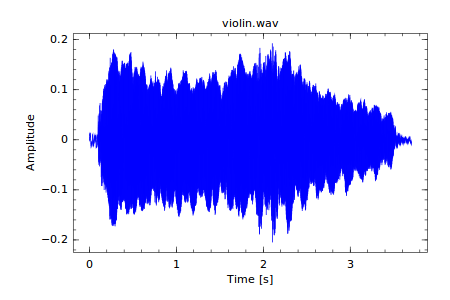

In [29]:
# vzorkovací frekvence je fs, časový krok mezi vzorky
# proto je 1/fs sekund.
plot(Float64[k*1/fs for k = 1:length(y)], y, "b")
xlabel("Time [s]")
ylabel("Amplitude")
title("violin.wav")

Nenechte se zmást. Předchozí graf sice vypadá jako skvrna, ale skutečně jde o záznam jistých oscilací. Podívejme se na kratší časový interval.

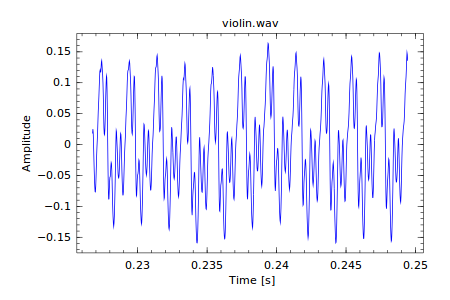

In [38]:
indmin = 10000
indmax = 11000
plot(Float64[k*1/fs for k = indmin:indmax], y[indmin:indmax], "b")
xlabel("Time [s]")
ylabel("Amplitude")
title("violin.wav")

### FFT

Naivní implementace FFT.

$$ \hat x_k = \sum_{j=0}^{n-1} x_k e^{-2i\pi kj/n}\,, \quad k = 0,1,\ldots,n-1\,. $$


In [51]:
function naiveFFT(data::Vector{Complex64})
    n = length(data)
    ft = Array(Complex64,(n,1))
    for k in 0:n-1
        ft[k+1] = sum(j->data[j+1]*exp(-2im*pi*k*j/n),0:n-1)
    end
    return ft
end
naiveFFT(data::Vector{Float64}) = naiveFFT(convert(Vector{Complex64},data))

naiveFFT (generic function with 2 methods)

FFT pomocí Cooley-Tukey algoritmu, rekurze.

In [43]:
function myFFT(data::Vector{Complex64})
    n, halfn = length(data), div(length(data),2)
    if n == 2
        return Complex64[data[1] + data[2], data[1] + exp(-pi*1im)*data[2]]
    else
        even = myfft(data[1:2:n-1])
        odd = myfft(data[2:2:n])
        return Complex64[ even[mod(k,halfn)+1] + exp(-2im*pi*k/n)*odd[mod(k,halfn)+1] for k = 0:n-1]
    end
end
myFFT(data::Vector{Float64}) = myfft(convert(Vector{Complex64},data))

myFFT (generic function with 2 methods)

Julia má samozřejmě FFT k dispozici ve vlastní implementaci pomocí funkce `fft`. Dle dostupných informací (zdrojový kód [julia/base/fftw.jl](https://github.com/JuliaLang/julia/blob/master/base/fftw.jl)) Julia využívá knihovny [FFTW](http://www.fftw.org/).

Porovnejme rychlosti (čas) a výsledky těchto tří funkcí na náhodných datech. Upozorňujeme, že je vždy potřeba funkce invokovat aspoň dvakrát, při prvním volání se kompilují (Julia využívá JIT).

In [44]:
# náhodný vektor dély 1024
data = rand(1024);

In [56]:
@time naivedata = naiveFFT(data);

elapsed time: 0.859227577 seconds (184615216 bytes allocated, 16.97% gc time)


In [57]:
@time mydata = myFFT(data);

elapsed time: 0.00491355 seconds (293840 bytes allocated)


In [58]:
@time jdata = fft(data);

elapsed time: 0.000182189 seconds (18376 bytes allocated)


In [65]:
println("Maximální absolutní rozdíly ve složkách výstupu")
println("Naivní vs. naše FFT: ", maximum(abs(naivedata - mydata)))
println("Naše FFT vs. FFTW ", maximum(abs(mydata - jdata)))

Maximální absolutní rozdíly ve složkách výstupu
Naivní vs. naše FFT: 1.1463942e-5
Naše FFT vs. FFTW 2.5066827106456913e-5


In [73]:
kstart = 4
klen = 5
telapsed = Array(Float64,(klen,4))
for k in kstart:kstart+klen-1
    println(k)
    data = rand(2^k)
    telapsed[k-kstart+1,:] = [2^k,@elapsed(naiveFFT(data)), @elapsed(myFFT(data)), @elapsed(fft(data))]
end
println("Done!")

4
5
6
7
8
Done!


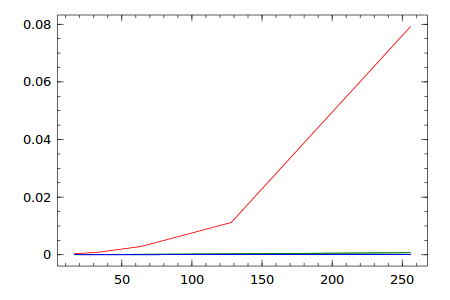

In [81]:
plot(telapsed[:,1],telapsed[:,2],"r")
hold(true)
plot(telapsed[:,1],telapsed[:,3],"g")
plot(telapsed[:,1],telapsed[:,4],"b")

In [86]:
hold()
plot(telapsed[:,1],telapsed[:,3],"g")
hold(true)
plot(telapsed[:,1],telapsed[:,4],"b")
hold()

false

### Spektrogram

Hanningova funkce.

In [24]:
# Hanning window of length n.
function hanning(n::Integer)
    [0.5*(1 - cos(2*pi*k/(n-1))) for k=0:(n-1)]
end

hanning (generic function with 1 method)

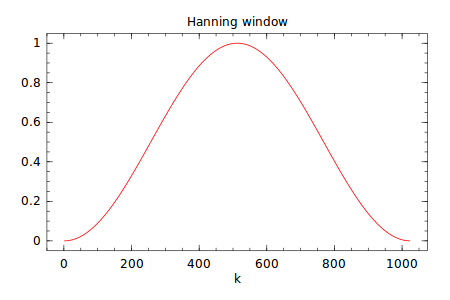

In [88]:
plot(1:1024, hanning(1024),"r")
xlabel("k")
title("Hanning window")

 25ms Hanning windows and 10ms overlap.

In [110]:
function spec(data::Vector{Float64}, freq::Real, wlen::Float64=0.025, overlap::Float64=0.01; maxfreq=pi*freq, logscale=true)
    # délka záznamu (počet vzorků
    n = length(data)
    # délka okénka (počet vzorků)
    wn = round(Int64, wlen*freq)
    # základní frekvence
    bfreq = freq/wn
    # délka překryvu (počet vzorků)
    overlapn = round(Int64, overlap*freq)
    # předpočítání Hanningovy funkce
    hanw = hanning(wn)
    # pole kam budeme zapisovat výsledky
    spectrum = Array(Complex64, (wn,0))
    # průběžný index
    k = 0
    while k + wn < n
        # aplikace Hanningovy funkce
        spectrum = hcat(spectrum, fft(data[k+1:k+wn] .* hanw))
        k += wn - overlapn
    end
    if logscale
        imgdata = map(x -> log(1+abs(x)^2), spectrum)
    else
        imgdata = map(x -> abs(x)^2, spectrum)
    end
    imagesc((0,n/freq), (maxfreq,0), imgdata[1:floor(Int64,maxfreq/bfreq),:])
    ylabel("Frequency [Hz]")
    xlabel("Time [s]")
    title("Spectrogram")
end

spec (generic function with 3 methods)

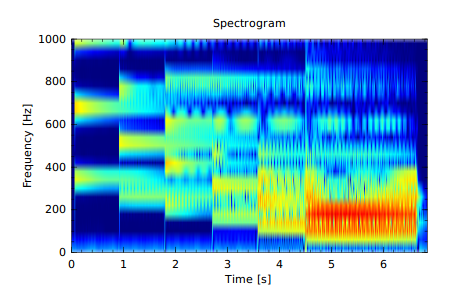

In [112]:
spec(y[:,1], fs, maxfreq=1000)


## Generování tónu

In [113]:
gtuning = {
    :e4 => 329.63,
    :b3 => 246.94,
    :g3 => 196.00,
    :d3 => 146.83,
    :a2 => 110.00,
    :e2 => 82.41
}

Dict{Any,Any} with 6 entries:
  :b3 => 246.94
  :d3 => 146.83
  :e2 => 82.41
  :e4 => 329.63
  :a2 => 110.0
  :g3 => 196.0

In [114]:
function sinwave(freq::Float64, sfreq::Real, duration::Float64)
    n = floor(Int64,duration*sfreq)
    return Float64[ sin(2*pi*freq * k/sfreq) for k in 1:n]
end

sinwave (generic function with 2 methods)

In [115]:
fs = 44100
y = sinwave(gtuning[:e4], fs, 3.0);

In [116]:
wavplay(y,fs)

In [117]:
wave = vcat(
    sinwave(gtuning[:e4], fs, 2.0),
    sinwave(gtuning[:b3], fs, 2.0),
    sinwave(gtuning[:g3], fs, 2.0),
    sinwave(gtuning[:d3], fs, 2.0),
    sinwave(gtuning[:a2], fs, 2.0),
    sinwave(gtuning[:e2], fs, 2.0)
    );
wavplay(wave, fs)

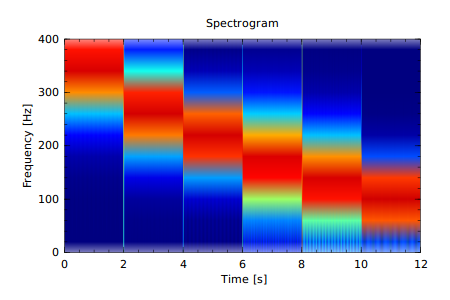

In [118]:
spec(wave, fs, maxfreq=400)

In [64]:
function normalizesum(args...)
    s = +(args...)
    m = maximum(abs(s))
    return 1/m .* s
end

normalizesum (generic function with 1 method)

In [65]:
normalizesum([1,2],[3,4])

2-element Array{Float64,1}:
 0.666667
 1.0     

In [78]:
saw = normalizesum(
    2*sinwave(gtuning[:e4], fs, 3.0),
    -1*sinwave(2*gtuning[:e4], fs, 3.0),
    2/3 * sinwave(3*gtuning[:e4], fs, 3.0),
    -2/4 * sinwave(4*gtuning[:e4], fs, 3.0),
    +2/5 * sinwave(5*gtuning[:e4], fs, 3.0),
    -2/6 * sinwave(6*gtuning[:e4], fs, 3.0),
);

In [79]:
wavplay(saw, fs)

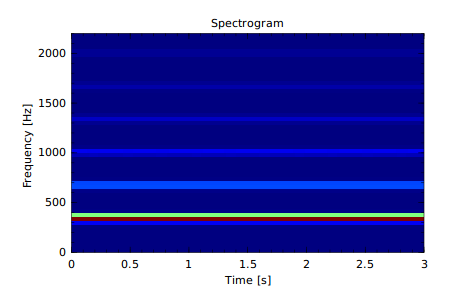

In [80]:
spec(saw,fs,maxfreq=2200)

## Kytara

In [129]:
y, fs, nbits = wavread("guitar_m.wav");

In [130]:
println("Frekvence: $fs")
println("Bitů: $nbits")
println("Prvních deset vzorků:")
println(y[1:10])

Frekvence: 44100
Bitů: 16
Prvních deset vzorků:
[-0.2888882106997894,-0.29157383953367716,-0.2945341349528489,-0.29517502365184484,-0.282967619861446,-0.2403027436140019,-0.16266365550706505,-0.07882930997650074,-0.03579821161534471,-0.05444502090517899]


In [131]:
wavplay(y,fs)

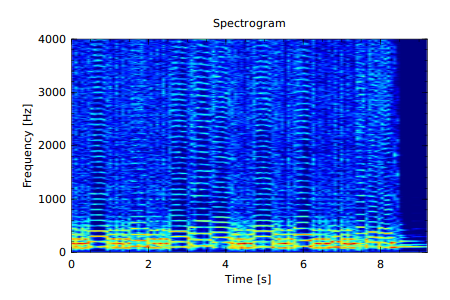

In [133]:
spec(y[:,1], fs, 0.1, 0.02, maxfreq=4000)